In [1]:
import sys
if (path := "C:/Users/Tom/PycharmProjects/python-hvac") not in sys.path:
    sys.path.append(path)

In [2]:
from hvac import Quantity, print_doc_string
from hvac.charts import LineChart

Q_ = Quantity

# Chapter 2: Conduction Heat Gain Through a Vertical Exterior Wall
---

Once we know how to create construction assemblies, as demonstrated in notebook no. 1, we can continue to create exterior building elements. There are two types of building elements: exterior building elements, that separate a thermal zone in a building from the outdoor environment, and interior building elements that separate a thermal zone from adjacent thermal zones in the building. In this notebook no. 2 it is demonstrated how an exterior building element is created and how to determine the conduction heat gain through an exterior building element for a given interior, zone-air temperature.

## Introducing the 'ExteriorBuildingElement' Class

A vertical exterior wall can be modeled by the `ExteriorBuildingElement` class.

In [3]:
from hvac.cooling_load_calc import ExteriorBuildingElement

In [4]:
print_doc_string(ExteriorBuildingElement)

Represents an opaque exterior building element.

An exterior building element is on one side exposed to the outdoor
environment. The temperature on the exterior surface of the building element
is the sol-air temperature. The sol-air-temperature will be calculated using
the given climatic design information valid for the specified design day on 
the specified geographic location. 

The location, the design day and all climatic design information are
encapsulated in an instance of class `WeatherData`.

The material construction of an exterior building element is defined by its
construction assembly, an object of class `ConstructionAssembly`.

The conductive heat transfer through an exterior building element depends on
its thermal mass (thermal inertia). To determine this time-dependent heat 
transfer, the exterior building element is modeled by a linear thermal 
network consisting of temperature nodes, which have a thermal capacitor 
(a "heat reservoir") and which are interconnected by t

To create an instance of the `ExteriorBuildingElement` class, we call its class method `create()`.

In [5]:
print_doc_string(ExteriorBuildingElement.create)

Creates an `ExteriorBuildingElement` object.

Parameters
----------
name:
    Identifies the exterior building element.
gross_area:
    Gross surface area of the exterior building element, i.e. also
    including any large openings, such as doors and windows.
constr_assem:
    Construction assembly the exterior building element is made of.
weather_data:
    Instance of class `WeatherData` encapsulating the climatic design
    information needed to determine the solar radiation incident on the
    exterior surface of the building element and its sol-air temperature
    during the design day, which was specified on instantiation of the
    `WeatherData` object.
azimuth_angle:
    The azimuth angle of the exterior building element. South = 0°,
    West = +90° and East = -90°.
slope_angle:
    Slope angle of the exterior building element. E.g., a vertical
    exterior wall has a slope angle of 90°.
surface_color: optional
    Either a 'dark' (default) or 'light' colored surface.
R_surf: op

When we want to create an instance of class `ExteriorBuildingElement`, we see in the docstring, among other things, that we need to pass the construction assembly of the building element and also the weather data that is needed to compute the heat flow through the vertical exterior wall. 

## The 'WeatherData' and the 'Location' Class

First, we will collect the weather data in a `WeatherData` object. This object is used to determine hourly profiles of the dry-bulb and wet-bulb outdoor air temperature and hourly profiles of solar radiation incident on the vertical exterior wall.  

In [6]:
from hvac.cooling_load_calc import WeatherData
from hvac.sun import Location, ClimateType, ReferenceDates

To create the `WeatherData` object, we will use climatic design data taken from ASHRAE valid for the geographical location under consideration. To determine the path of the sun, we also need to give some details about the geographical location of the building. For this, we will instantiate the `Location` class.

In [7]:
print_doc_string(Location.__init__)

Creates a `Location` object for which the solar path and the solar
radiation can be determined at a given date and solar time.

Parameters
----------
fi:
    Latitude of the location; north positive; -pi/2 <= fi <= pi/2
L_loc:
    Longitude of the location; positive east of Greenwich, negative
    west of Greenwich.
date: Date, optional
    Current date at the location.
solar_time: Time, optional
    Current solar time at the location.
altitude: Quantity, optional
    Altitude of the location.
climate_type:
    Type of climate as defined in class `ClimateType`
timezone: optional, default UTC
    Tz-database identifier of the time zone of the location, indicating
    the offset from UTC (e.g. Etc/GMT-1).
    See: https://en.wikipedia.org/wiki/List_of_tz_database_time_zones
    The time zone is only used to determine the local standard time
    meridian. Do not specify a timezone with daylight saving time (DST),
    should it be in use at the location under consideration, as this may
   

In [8]:
location = Location(
    fi=Q_(51.183, 'deg'),
    L_loc=Q_(3.8, 'deg'),
    altitude=Q_(8, 'm'),
    climate_type=ClimateType.MID_LATITUDE_SUMMER,
    timezone='Etc/GMT-1'
)

Now we can instantiate the `WeatherData` class.

In [9]:
print_doc_string(WeatherData.create_from_climatic_design_data)

Creates a `WeatherData` object from information that can be looked up 
in e.g. ASHRAE's climatic design data tables.

Parameters
----------
location:
    Geographic location for which the weather data is valid.
date:
    Date for which the weather data is valid, i.e. the "design day".
T_db_des:
    Monthly design dry-bulb temperature, i.e., the maximum temperature
    on the selected day.
T_db_rng:
    Mean daily temperature range, i.e., the difference between the
    maximum and the minimum temperature on the selected day.
T_wb_mc:
    Mean coincident wet-bulb temperature.
T_wb_rng:
    Mean coincident daily wet-bulb temperature range.
H_avg: optional
    Monthly average daily global radiation on a horizontal surface.
K_T_avg: optional
    Monthly average daily clearness index.

Notes
-----
1. If neither `H_avg`, nor `K_T_avg` is specified, the clear-sky model
will be used to determine solar radiation incident on surfaces.

2. Hourly values of dry-bulb and wet-bulb temperature are det

In [10]:
weather_data = WeatherData.create_from_climatic_design_data(
    location=location,
    date=ReferenceDates.get_date_for('Jun'),  # this returns the "design day" for June
    T_db_des=Q_(24.2, 'degC'),
    T_db_rng=Q_(11.8, 'K'),
    T_wb_mc=Q_(18.0, 'degC'),
    T_wb_rng=Q_(5.6, 'K')
)

## Loading the Construction Assembly

We will use the construction assembly that we have created and saved on a shelf in the previous notebook no. 1.

In [11]:
from hvac.cooling_load_calc import ConstructionAssembly

In [12]:
ConstructionAssembly.db_path = "./construction_shelf/assemblies"
constr_assem = ConstructionAssembly.load('exterior-wall')

We can have a look at the layers the construction assembly is composed of.

In [13]:
print(constr_assem)

construction assembly: exterior-wall
SurfaceFilm 'ext-surf-film': t = 0.000 m, R = 0.04 K·m²/W, C = 0.00 J/K/m², nodes = 1
SolidLayer 'brick-wall-15': t = 0.150 m, R = 0.09 K·m²/W, C = 189000.00 J/K/m², nodes = 5
AirLayer 'air-layer': t = 0.050 m, R = 0.15 K·m²/W, C = 0.00 J/K/m², nodes = 1
SolidLayer 'brick-wall-18': t = 0.180 m, R = 0.11 K·m²/W, C = 226800.00 J/K/m², nodes = 6
SolidLayer 'gypsum': t = 0.015 m, R = 0.03 K·m²/W, C = 16380.00 J/K/m², nodes = 1
SurfaceFilm 'int-surf-film': t = 0.000 m, R = 0.13 K·m²/W, C = 0.00 J/K/m², nodes = 1



## Instantiating the 'ExteriorBuildingElement' Class

Now we have everything to instantiate the `ExteriorBuildingElement` object.

In [14]:
ext_wall = ExteriorBuildingElement.create(
    name='exterior-wall',
    gross_area=Q_(10, 'm') * Q_(3, 'm'),  # surface area of the wall
    constr_assem=constr_assem,
    weather_data=weather_data,
    azimuth_angle=Q_(0, 'deg'),  # oriented to the south
    slope_angle=Q_(90, 'deg')   # vertical wall
)

## Conduction Heat Gain through the Exterior Vertical Wall

Once an exterior building element has been instantiated, we can use it to determine its conduction heat gain on the selected design day, which we have specified when instantiating the `WeatherData` object.

To calculate the heat flow on the interior side of the exterior wall, a linear thermal network model of the wall is used to take the effect of the distributed thermal capacity of the wall materials ("thermal mass", "thermal inertia") into account. The number of temperature nodes in the linear thermal network is determined by the number of slices that were assigned when creating the solid construction layers of the construction assembly. When we printed the construction assembly of the wall in a code block above, the number of temperature nodes (slices) of each layer were also indicated. 

The heat flow at the interior side (i.e. the actual conduction heat gain) is also split into a convective fraction, which is directly transferred to the zone air, and a radiative fraction, which is transferred to the internal mass of the zone, according to the Radiant-Time-Series (RTS) method of ASHRAE. The default radiative fraction is set to 0.46. This fraction can be modified through parameter `F_rad` in the call to `create()` when instantiating the exterior building element. Appropriate values for this parameter can be found e.g. in ASHRAE Handbook 2017, Chapter 18, Table 14.

In [15]:
Q_cnd, Q_cnd_cv, Q_cnd_rad = ext_wall.conduction_heat_gain(T_za=Q_(22, 'degC'))

Parameter `T_za` is the fixed zone-air temperature on the interior side of the wall.

Method `conduction_heat_gain` returns the hourly values of the global conduction heat gain through the vertical exterior wall on the selected design day, the convective fraction of this conduction heat gain, and the radiative fraction of this conduction heat gain. We can display these values in a Pandas `DataFrame` object and also plot them on a line chart.

In [16]:
import pandas as pd

df = pd.DataFrame({
    'Q_cnd': Q_cnd.to('W').m,
    'Q_cnd_cv': Q_cnd_cv.to('W').m,
    'Q_cnd_rad': Q_cnd_rad.to('W').m
})
df

,Q_cnd,Q_cnd_cv,Q_cnd_rad
0,449.609328,242.789037,206.820291
1,398.183728,215.019213,183.164515
2,340.451624,183.843877,156.607747
3,278.727804,150.513014,128.214790
4,215.374823,116.302404,99.072419
5,152.891135,82.561213,70.329922
6,93.723484,50.610681,43.112803
7,40.788875,22.025993,18.762883
8,-2.798464,-1.511170,-1.287293
9,-33.617429,-18.153412,-15.464017


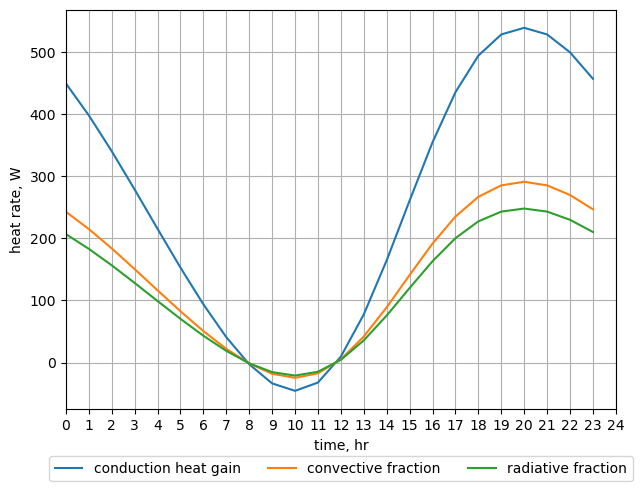

In [17]:
chart = LineChart()
chart.add_xy_data(
    label='conduction heat gain',
    x1_values=df.index,
    y1_values=df['Q_cnd']
)
chart.add_xy_data(
    label='convective fraction',
    x1_values=df.index,
    y1_values=df['Q_cnd_cv']
)
chart.add_xy_data(
    label='radiative fraction',
    x1_values=df.index,
    y1_values=df['Q_cnd_rad']
)
chart.add_legend(columns=3)
chart.x1.add_title('time, hr')
chart.y1.add_title('heat rate, W')
chart.x1.scale(0, 25, 1)
chart.show()